# Logistic Regression
With Jax

In [1]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Import Course Code 

In [2]:
from src import Logistic_Regression, Tools

## Generate Data

In [362]:
tools = Tools()
X, Y = tools.GenerateData(n_samples=200, n_classes=3, dim=2)
X_val, Y_val = tools.GenerateData(n_samples=50, n_classes=3, dim=2)

In [363]:
X.shape, Y.shape

((2, 600), (600,))

Text(0.5, 1.0, 'Data Space')

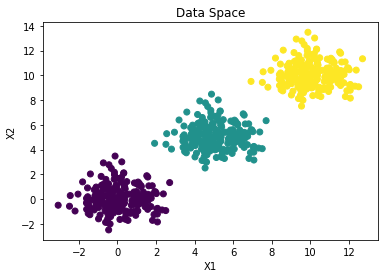

In [364]:
plt.scatter(X[0,:], X[1,:], c = Y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Data Space")

## Model

In [365]:
model = Logistic_Regression()
model.fit(X, Y)

-676.342529296875
-7.675016403198242
-7.383470058441162
-7.13415002822876
-6.9269843101501465
-6.749616622924805
-6.593408107757568
-6.462484359741211
-6.34357213973999
-6.2360334396362305
-6.135219573974609
-6.04167366027832
-5.9582319259643555
-5.8834967613220215
-5.813196182250977
-5.746143817901611
-5.680942058563232
-5.619060516357422
-5.559511184692383
-5.5014142990112305
-5.444899559020996
-5.391321659088135
-5.3399810791015625
-5.2898430824279785
-5.243120193481445
-5.198091506958008
-5.155368804931641
-5.114501476287842
-5.075035095214844
-5.036285877227783
-4.998775005340576
-4.962931156158447
-4.927675724029541
-4.892994403839111
-4.858874797821045
-4.825296401977539
-4.792852878570557
-4.76129674911499
-4.730490684509277


## Inference

In [369]:
Y_hat = model.estimate(X_val)
Y_hat

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [368]:
model.precision(Y_val, Y_hat)

1.0

## Get probabilities for each instance

In [20]:
X_prob = model.estimate_prob(X)
X_prob.shape

(3, 600)

In [21]:
X_prob[:, 0]

DeviceArray([9.9998540e-01, 1.4583755e-05, 4.3148540e-15], dtype=float32)

In [25]:
jnp.sum(X_prob[:, 1])

DeviceArray(1.0000001, dtype=float32)

## Regularization

In [371]:
class Regularized_Logistic_Regression(Logistic_Regression):
    def __init__(self, regularization, method_opt='regularized_model', lmbda:float=1.0, debug = False):
        super().__init__(regularization, method_opt)
        self.lmbda = lmbda
        self.debug = debug

    # @partial(jit, static_argnums=(0,))
    def model(self, W:jnp, X:jnp, Y_hot:jnp)->jnp:
        """
        Logistic Model
        """
        W = jnp.reshape(W, self.sh)
        terms = self.logistic_exp(W, X)
        sum_terms = self.logistic_sum(terms)
        matrix = self.logit_matrix(terms, sum_terms)
        
        if self.regularization == "l1":
            # Regularization l1
            reg = self.lmbda/(X.shape[1]) * jnp.sum(jnp.abs(W))
        else:
            # Regularization l2
            reg = self.lmbda/(X.shape[1]) * jnp.trace(jnp.transpose(W)@W)

        return jnp.sum(jnp.sum(jnp.log(matrix)*Y_hot, axis=0), axis=0) + reg

    def regularized_model(self, W:jnp, X:jnp, Y_hot:jnp, alpha:float=1e-2, tol:float=1e-3)->jnp:
        """
        The regularized version of the logistic regression
        """
        n, m = W.shape 
        self.sh = (n, m)
        alpha = 0.5
        Grad = jax.grad(self.model, argnums=0)(jnp.ravel(W), X, Y_hot)
        loss = self.model(jnp.ravel(W), X, Y_hot)
        cnt = 0

        while cnt < 200:
            Hessian = jax.hessian(self.model, argnums=0)(jnp.ravel(W), X, Y_hot)
            W = W - alpha * jnp.reshape((jnp.linalg.inv(Hessian)@Grad) , self.sh)
            Grad =  jax.grad(self.model, argnums=0)(jnp.ravel(W), X, Y_hot)
            old_loss = loss
            loss = self.model(jnp.ravel(W), X, Y_hot)

            if cnt%30 == 0 and self.debug:
                print(f'{self.model(jnp.ravel(W), X, Y_hot)}')
                
            if  jnp.abs(old_loss - loss) < tol:
                break

            cnt +=1

        return W

In [372]:
reg_model = Regularized_Logistic_Regression(
    regularization = "l2",
    method_opt = 'regularized_model',
    lmbda = 1,
    debug = True
)

reg_model.fit(X, Y)
Y_hat = reg_model.estimate(X_val)
model.precision(Y_val, Y_hat)

-676.6201782226562
-5.128867149353027
-4.933996200561523
-4.769298553466797
-4.621235370635986
-4.4839186668396
-4.35713005065918


1.0

In [373]:
Y_hat

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [377]:
accuracy_score(Y_val, Y_hat)

1.0

In [319]:
lmbdas = [0, 0.1, 1, 3, 5, 10, 20, 50]
precision_list_l1 = []
precision_list_l2 = []

for l in lmbdas:
    # For l1 Regularization
    reg_model = Regularized_Logistic_Regression(
        regularization = "l1",
        method_opt = 'regularized_model',
        lmbda = l)
    reg_model.fit(X, Y)
    Y_hat = reg_model.estimate(X_val)
    precision_list_l1.append(model.precision(Y_val, Y_hat))

    # For l2 Regularization
    reg_model = Regularized_Logistic_Regression(
        regularization = "l2",
        method_opt = 'regularized_model',
        lmbda = l,
    )
    reg_model.fit(X, Y)
    Y_hat = reg_model.estimate(X_val)
    precision_list_l2.append( model.precision(Y_val, Y_hat))

Text(0.5, 1.0, 'Lambda Grid Search')

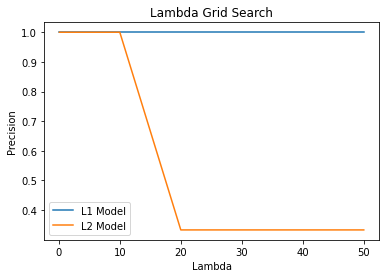

In [317]:
plt.plot(lmbdas, precision_list_l1, label = "L1 Model")
plt.plot(lmbdas, precision_list_l2, label = "L2 Model")
plt.xlabel("Lambda")
plt.ylabel("Precision")
plt.legend()
plt.title("Lambda Grid Search")
plt.plot();

## Case Study Dataset

In [3]:
import pandas as pd
from sklearn import preprocessing

url = "https://www.openml.org/data/download/1595261/phpMawTba"

df = pd.read_csv(url, header = None, skiprows=19, na_values=' ?')
le = preprocessing.LabelEncoder()
df[14] = le.fit_transform(df[14])
df = df.dropna()
df = pd.get_dummies(df)
df.head()

,0,2,4,10,11,12,14,1_ Federal-gov,1_ Local-gov,1_ Private,...,13_ Portugal,13_ Puerto-Rico,13_ Scotland,13_ South,13_ Taiwan,13_ Thailand,13_ Trinadad&Tobago,13_ United-States,13_ Vietnam,13_ Yugoslavia
0,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [4]:
from sklearn.preprocessing import MinMaxScaler

y = df[14].values
X = df.drop([14], axis = 1).values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.30,
    random_state=42,
    stratify = y
)

In [6]:
# To work properly with Model Class
X_train = np.swapaxes(X_train,0,1)
X_test = np.swapaxes(X_test,0,1)

In [397]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

lmbdas = [0, 1]
acc_list_l2 = []
rec_list_l2 = []


reg_model = Regularized_Logistic_Regression(
    regularization = "l2",
    method_opt = 'regularized_model',
    lmbda = 0,
)
reg_model.fit(X_train, y_train)
Y_hat = reg_model.estimate(X_test)
acc_list_l2.append(accuracy_score(y_test, Y_hat))
rec_list_l2.append(recall_score(y_test, Y_hat, average='binary'))
    

KeyboardInterrupt: 

In [7]:
model = Logistic_Regression()
model.fit(X_train, y_train)

-99495.703125
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [400]:
X_train.shape, y_train.shape

((104, 31655), (31655,))

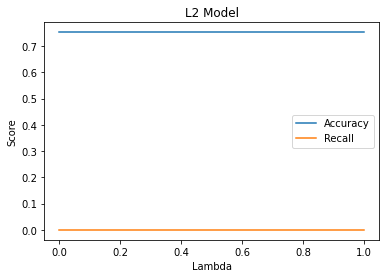

In [388]:
plt.plot(lmbdas, acc_list_l2, label = "Accuracy")
plt.plot(lmbdas, rec_list_l2, label = "Recall")
plt.xlabel("Lambda")
plt.ylabel("Score")
plt.legend()
plt.title("L2 Model")
plt.plot();

In [342]:
reg_model.W.shape

(1, 105)

In [344]:
acc_list_l2

[0.7548463182722783,
 0.7548463182722783,
 0.7548463182722783,
 0.7548463182722783,
 0.7548463182722783]

In [345]:
rec_list_l2

[0.0, 0.0, 0.0, 0.0, 0.0]